In [196]:
## imports
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  
import seaborn as sns
import pyarrow.ipc as pa_ipc
from scipy.stats import spearmanr, pearsonr

In [197]:
## func zoo
def load_reference_arrows(path='/grid/wsbs/home_norepl/pmantill/Motif_swap_experiment/Foreground_optimization/reference_foreground_results/DeepLIFT_SEAM_param_comparison/Reference_arrows'):
    # get all reference arrows (seq0-seq14)
    ref_arrows = []
    for i in range(15):
        arrow_path = f"{path}/Seq{i}/seq{i}_task1.arrow"
        if not os.path.exists(arrow_path):
            raise FileNotFoundError(f"Missing Arrow file: {arrow_path}")
        with pa_ipc.open_file(arrow_path) as reader:
            ref_arrows.append(reader.read_all())

    return ref_arrows

    
def load_param_arrow(path, seq):
    # Load single arrow file for param set and sequence
    arrow_path = f"{path}/seq{seq}_task1.arrow"
    if not os.path.exists(arrow_path):
        #print(f"Missing Arrow file: {arrow_path}")
        return None
    with pa_ipc.open_file(arrow_path) as reader:
        param_arrow = reader.read_all()
    
    return param_arrow

def unpack_attribution_from_arrow(arrow_table):
    """Unpack attribution maps from arrow table."""
    # Get the stored data
    row = arrow_table.to_pandas().iloc[0]
    
    # Parse shapes and dtypes
    shapes = row['array_shapes'].split('|')
    dtypes = row['array_dtypes'].split('|')
    
    # Dictionary to store all attribution maps
    attributions = {}
    
    # Define the field names and their order (must match save order in script)
    field_names = [
        'background_averaged_over_all_clusters',
        'wt_cluster_foreground', 
        'wt_cluster_scaled_foreground',
        'wt_cluster_specific_background',
        'scaled_background'
    ]
    
    # Unpack each attribution map
    for i, field_name in enumerate(field_names):
        # Get bytes data
        bytes_data = row[field_name]
        
        # Parse shape and dtype
        shape = eval(shapes[i])
        dtype = np.dtype(dtypes[i])
        
        # Reconstruct array from bytes
        arr = np.frombuffer(bytes_data, dtype=dtype).reshape(shape)
        attributions[field_name] = arr
    
    # Get metadata
    metadata = arrow_table.schema.metadata
    attributions['metadata'] = {
        'seq_index': int(metadata[b'seq_index'].decode()),
        'task_index': int(metadata[b'task_index'].decode()),
        'num_seqs': int(metadata[b'num_seqs'].decode()),
        'n_clusters': int(metadata[b'n_clusters'].decode()),
        'clustering_method': metadata[b'clustering_method'].decode(),
        'runtime_seconds': float(metadata[b'runtime_seconds'].decode())
    }
    
    return attributions

def compare_maps(ref_arrow, param_arrow, orig_bin):
    """Compare reference and parameter attributions using Spearman and Pearson correlation."""
    from scipy.stats import spearmanr, pearsonr
    
    results_list = []
    # Unpack attributions
    ref_attrs = unpack_attribution_from_arrow(ref_arrow)
    param_attrs = unpack_attribution_from_arrow(param_arrow)
    
    # Get metadata
    ref_meta = ref_attrs['metadata']
    param_meta = param_attrs['metadata']
    
    # Compare each attribution map type
    comparison_types = [
        'background_averaged_over_all_clusters',
        'wt_cluster_foreground',
        'wt_cluster_scaled_foreground', 
        'wt_cluster_specific_background',
        'scaled_background'
    ]
    
    for attr_type in comparison_types:
        ref_map = ref_attrs[attr_type].flatten()
        param_map = param_attrs[attr_type].flatten()
        
        # Compute correlations
        spearman_corr, spearman_pval = spearmanr(ref_map, param_map)
        pearson_corr, pearson_pval = pearsonr(ref_map, param_map)
        
        # Store results
        result = {
            'seq_index': ref_meta['seq_index'],
            'attribution_type': attr_type,
            'param_num_seqs': param_meta['num_seqs'],
            'param_n_clusters': param_meta['n_clusters'],
            'param_clustering_method': param_meta['clustering_method'],
            'spearman_corr': spearman_corr,
            'pearson_corr': pearson_corr,
            'ref_runtime': ref_meta['runtime_seconds'],
            'param_runtime': param_meta['runtime_seconds'],
            'bin': orig_bin
        }
        results_list.append(result)
    
    return results_list




In [198]:
# Main

# in Kmeans_param_sweep get all file strings
# get all num_seqs, n_clusters pairs

from pathlib import Path

import os
folder = '/grid/wsbs/home_norepl/pmantill/Motif_swap_experiment/Foreground_optimization/reference_foreground_results/DeepLIFT_SEAM_param_comparison/Kmeans_param_sweep'
files = sorted([f for f in os.listdir(folder) if f.startswith('parameter_set_')])

num_seqs = []
n_clusters = []
for f in files:
    f = f.split('_')
    num_seqs.append(int(f[2]))
    n_clusters.append(int(f[3]))
num_seqs = [int(x) for x in num_seqs]
n_clusters = [int(x) for x in n_clusters]


param_sweep_df = pd.DataFrame({'num_seqs': num_seqs, 'n_clusters': n_clusters})

print(f"Found {sorted(param_sweep_df['num_seqs'].unique())} num_seqs")
print(f"Found {sorted(param_sweep_df['n_clusters'].unique())} n_clusters")


ref_arrows = load_reference_arrows()
print(f"Loaded {len(ref_arrows)} reference arrows")

results_df = pd.DataFrame()

#### Not done yet, remvoe when done
#param_sweep_df = param_sweep_df[param_sweep_df['n_clusters'] != 50]

print(f'Making comparison for {len(param_sweep_df)} parameter sets...')



for i, row in param_sweep_df.iterrows():
    if i % 8 == 0:
        print(f"Processing parameter set {i+1} of {len(param_sweep_df)}")
    #print(f"Num seqs: {row['num_seqs']}, n_clusters: {row['n_clusters']}")
    num_seqs = row['num_seqs']
    n_clusters = row['n_clusters']
    for j in range(len(ref_arrows)):
        #print(f"Running comparison for seq {j}")
        ref_arrow_seq = ref_arrows[j]

        param_path = f"/grid/wsbs/home_norepl/pmantill/Motif_swap_experiment/Foreground_optimization/reference_foreground_results/DeepLIFT_SEAM_param_comparison/Kmeans_param_sweep/parameter_set_{row['num_seqs']}_{row['n_clusters']}_kmeans_results/Seq{j}"
        seq_param_map = load_param_arrow(param_path, j)


        if seq_param_map is None:
            print(f"No param map found for seq {j}, skipping")
            continue

        orig_library_df = pd.read_csv('../../../test_library_df.csv')

        orig_bin = orig_library_df.iloc[j]['bin']

        results = compare_maps(ref_arrow_seq, seq_param_map, orig_bin)

        results_df = pd.concat([results_df, pd.DataFrame(results)])

        # Add bin infor
        
        #print(f"Seq {j} is in bin {orig_bin}")
        #results_df.iloc[j]['bin'] = orig_bin

        
       
        # update .csv with param set performance and all metadata
results_df.tail()

    # load param arrows 

Found [100, 500, 1000, 5000, 10000, 50000] num_seqs
Found [10, 20, 30, 40, 50, 75] n_clusters
Loaded 15 reference arrows
Making comparison for 35 parameter sets...
Processing parameter set 1 of 35
Processing parameter set 9 of 35
Processing parameter set 17 of 35


/grid/wsbs/home_norepl/pmantill/miniconda3/envs/EvoAug2_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/grid/wsbs/home_norepl/pmantill/miniconda3/envs/EvoAug2_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/grid/wsbs/home_norepl/pmantill/miniconda3/envs/EvoAug2_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/grid/wsbs/home_norepl/pmantill/miniconda3/envs/EvoAug2_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not 

No param map found for seq 11, skipping
No param map found for seq 12, skipping
No param map found for seq 13, skipping
No param map found for seq 14, skipping
Processing parameter set 25 of 35
Processing parameter set 33 of 35


,seq_index,attribution_type,param_num_seqs,param_n_clusters,param_clustering_method,spearman_corr,pearson_corr,ref_runtime,param_runtime,bin
0,14,background_averaged_over_all_clusters,500,75,kmeans,0.945672,0.955802,2526.363153,12.920347,high
1,14,wt_cluster_foreground,500,75,kmeans,0.048636,0.970873,2526.363153,12.920347,high
2,14,wt_cluster_scaled_foreground,500,75,kmeans,0.232150,0.988836,2526.363153,12.920347,high
3,14,wt_cluster_specific_background,500,75,kmeans,0.537405,0.698992,2526.363153,12.920347,high
4,14,scaled_background,500,75,kmeans,0.945673,0.955799,2526.363153,12.920347,high


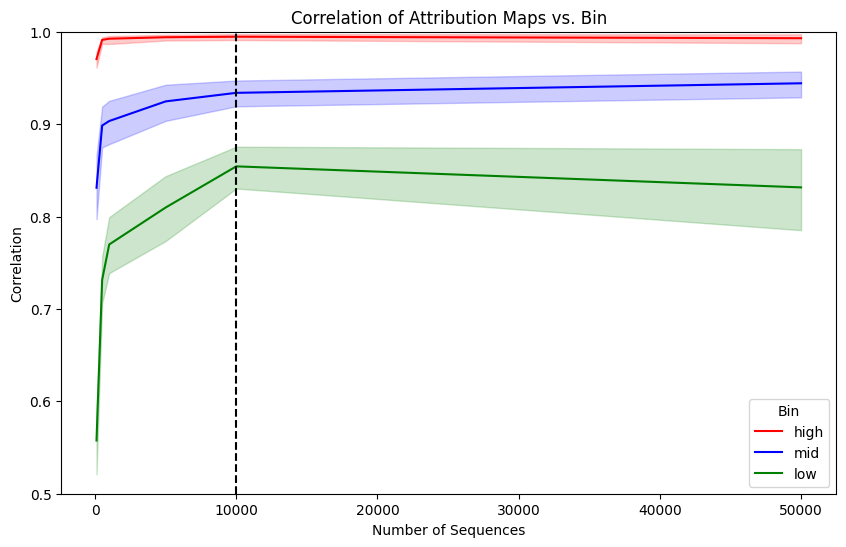

In [199]:
# plot result
plot_df = results_df[results_df['attribution_type'] == 'wt_cluster_scaled_foreground']


plt.figure(figsize=(10, 6))
sns.lineplot(x='param_num_seqs', y='pearson_corr', data=plot_df, hue='bin', palette=['red', 'blue', 'green'], hue_order=['high', 'mid', 'low'])
plt.title('Correlation of Attribution Maps vs. Bin')
plt.axvline(x=10000, color='black', linestyle='--')
plt.xlabel('Number of Sequences')
plt.ylabel('Correlation')
plt.ylim(0.50, 1)
plt.legend(title='Bin')

plt.savefig('correlation_vs_num_seqs_full_param_sweep.png', dpi=100)

plt.show()



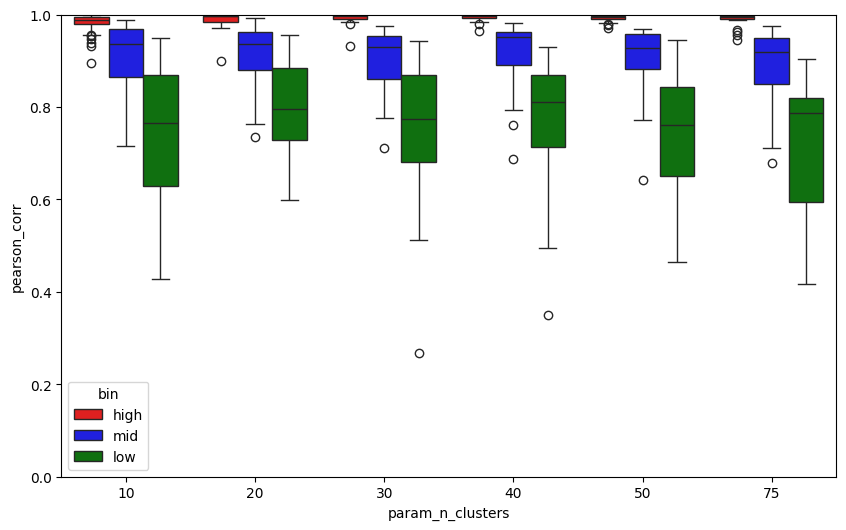

In [200]:
#lineplot_df = lineplot_df[lineplot_df['seq_index'] != 7]
plt.figure(figsize=(10, 6))
sns.boxplot(x='param_n_clusters', y='pearson_corr', data=plot_df, hue='bin', palette=['red', 'blue', 'green'], hue_order=['high', 'mid', 'low'])
plt.ylim(0, 1)

plt.savefig('correlation_vs_num_clusters_full_param_sweep.png', dpi=100)

plt.show()






In [201]:
seq_num = 10000
clus_num = 30
final_df = results_df
final_df.head()




,seq_index,attribution_type,param_num_seqs,param_n_clusters,param_clustering_method,spearman_corr,pearson_corr,ref_runtime,param_runtime,bin
0,0,background_averaged_over_all_clusters,10000,10,kmeans,0.988256,0.967245,2895.636839,126.797974,mid
1,0,wt_cluster_foreground,10000,10,kmeans,0.049962,0.919519,2895.636839,126.797974,mid
2,0,wt_cluster_scaled_foreground,10000,10,kmeans,0.723273,0.977380,2895.636839,126.797974,mid
3,0,wt_cluster_specific_background,10000,10,kmeans,0.939279,0.802634,2895.636839,126.797974,mid
4,0,scaled_background,10000,10,kmeans,0.988255,0.967246,2895.636839,126.797974,mid


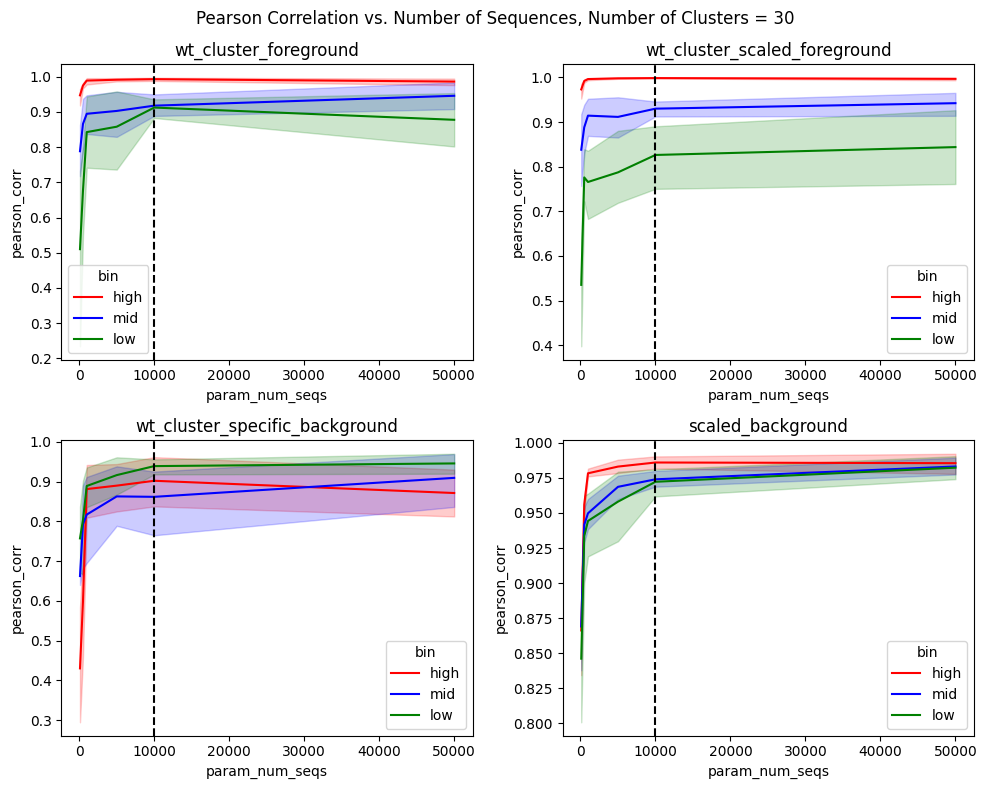

In [202]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

final_df = final_df[final_df['param_n_clusters'] == clus_num]

plt.suptitle('Pearson Correlation vs. Number of Sequences, Number of Clusters = 30')
# pearson corr vs num seqs for all 4 maps
sns.lineplot(x='param_num_seqs', y='pearson_corr',
             data=final_df[final_df['attribution_type']=='wt_cluster_foreground'],
             hue='bin', palette=['red','blue','green'],
             hue_order=['high','mid','low'],
             ax=axes[0,0])

axes[0,0].set_title('wt_cluster_foreground')
axes[0,0].axvline(x=10000, color='black', linestyle='--')

sns.lineplot(x='param_num_seqs', y='pearson_corr',
             data=final_df[final_df['attribution_type']=='wt_cluster_scaled_foreground'],
             hue='bin', palette=['red','blue','green'],
             hue_order=['high','mid','low'],
             ax=axes[0,1])

axes[0,1].set_title('wt_cluster_scaled_foreground')
axes[0,1].axvline(x=10000, color='black', linestyle='--')
sns.lineplot(x='param_num_seqs', y='pearson_corr',
             data=final_df[final_df['attribution_type']=='wt_cluster_specific_background'],
             hue='bin', palette=['red','blue','green'],
             hue_order=['high','mid','low'],
             ax=axes[1,0])

axes[1,0].set_title('wt_cluster_specific_background')
axes[1,0].axvline(x=10000, color='black', linestyle='--')
sns.lineplot(x='param_num_seqs', y='pearson_corr',
             data=final_df[final_df['attribution_type']=='scaled_background'],
             hue='bin', palette=['red','blue','green'],
             hue_order=['high','mid','low'],
             ax=axes[1,1])

axes[1,1].set_title('scaled_background')
axes[1,1].axvline(x=10000, color='black', linestyle='--')
plt.tight_layout()

plt.savefig('pearson_corr_vs_num_seqs_30_clusters.png', dpi=100)

plt.show()




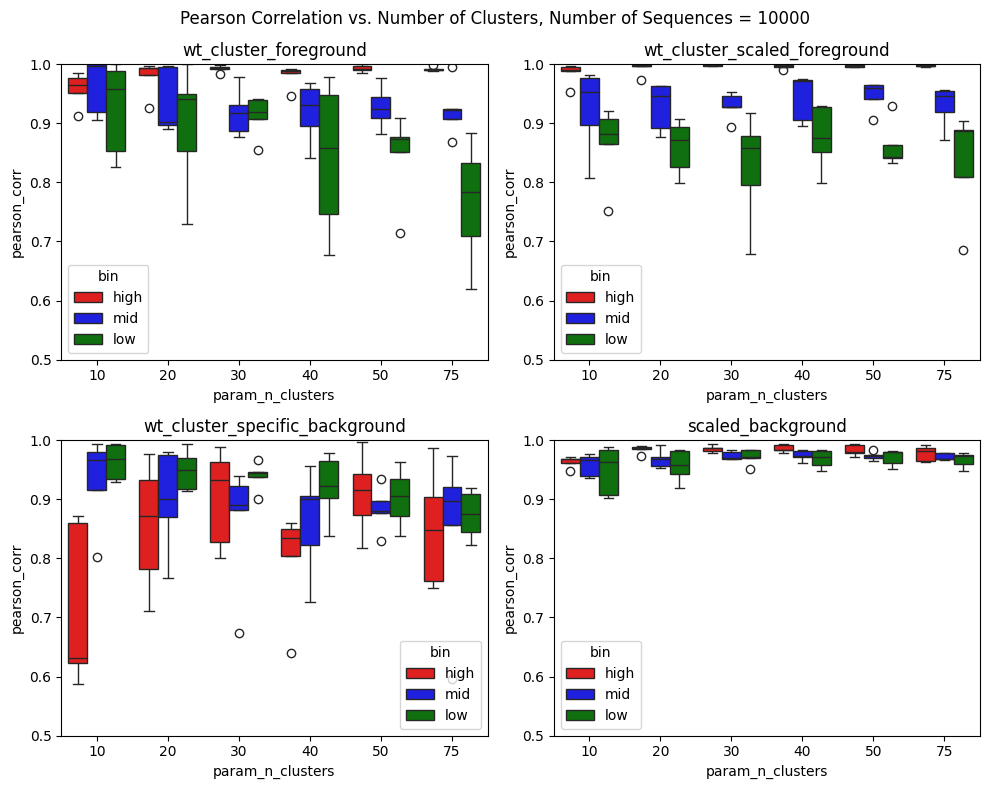

In [203]:
final_df = results_df
final_df = results_df[results_df['param_num_seqs'] == seq_num]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
plt.suptitle('Pearson Correlation vs. Number of Clusters, Number of Sequences = 10000')

# pearson corr vs num seqs for all 4 maps
sns.boxplot(x='param_n_clusters', y='pearson_corr',
             data=final_df[final_df['attribution_type']=='wt_cluster_foreground'],
             hue='bin', palette=['red','blue','green'],
             hue_order=['high','mid','low'],
             ax=axes[0,0])

axes[0,0].set_title('wt_cluster_foreground')
axes[0,0].set_ylim(0.5, 1)

sns.boxplot(x='param_n_clusters', y='pearson_corr',
             data=final_df[final_df['attribution_type']=='wt_cluster_scaled_foreground'],
             hue='bin', palette=['red','blue','green'],
             hue_order=['high','mid','low'],
             ax=axes[0,1])

axes[0,1].set_title('wt_cluster_scaled_foreground')
axes[0,1].set_ylim(0.5, 1)
sns.boxplot(x='param_n_clusters', y='pearson_corr',
             data=final_df[final_df['attribution_type']=='wt_cluster_specific_background'],
             hue='bin', palette=['red','blue','green'],
             hue_order=['high','mid','low'],
             ax=axes[1,0])

axes[1,0].set_title('wt_cluster_specific_background')
axes[1,0].set_ylim(0.5, 1)
sns.boxplot(x='param_n_clusters', y='pearson_corr',
             data=final_df[final_df['attribution_type']=='scaled_background'],
             hue='bin', palette=['red','blue','green'],
             hue_order=['high','mid','low'],
             ax=axes[1,1])

axes[1,1].set_title('scaled_background')
axes[1,1].set_ylim(0.5, 1)
plt.tight_layout()

plt.savefig('pearson_corr_vs_num_clusters_10000_seqs.png', dpi=100)

plt.show()

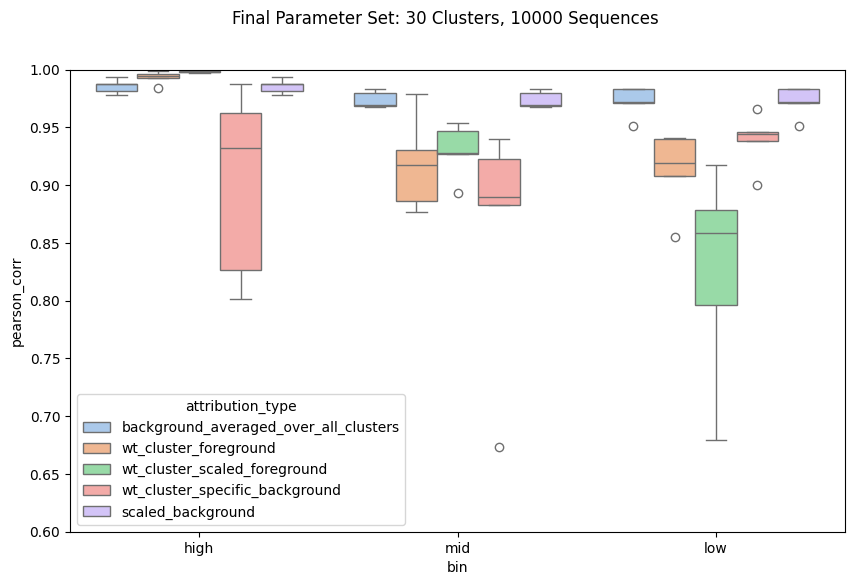

In [204]:
final_df = final_df[final_df['param_n_clusters'] == clus_num]

plt.figure(figsize=(10, 6))
plt.suptitle('Final Parameter Set: 30 Clusters, 10000 Sequences')
sns.boxplot(x='bin', y='pearson_corr', data=final_df, hue='attribution_type', order=['high','mid','low'], palette='pastel')
plt.ylim(0.6, 1)


plt.savefig('final_parameter_set_performance.png', dpi=100)

plt.show()






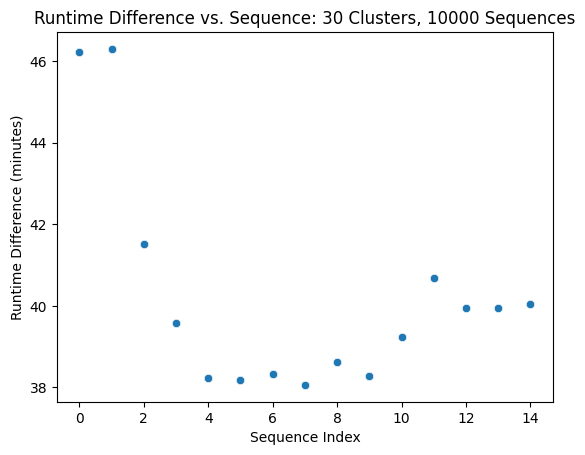

In [205]:
time_diff_df = final_df
#time_diff_df = time_diff_df.melt(id_vars=['seq_index'], var_name='runtime_type', value_name='runtime')
time_diff_df['runtime_diff'] = time_diff_df['param_runtime'] - time_diff_df['ref_runtime']
time_diff_df['runtime_diff'] = time_diff_df['runtime_diff'].abs()/60 
sns.scatterplot(x='seq_index', y='runtime_diff', data=time_diff_df)
plt.xlabel('Sequence Index')
plt.ylabel('Runtime Difference (minutes)')
plt.title('Runtime Difference vs. Sequence: 30 Clusters, 10000 Sequences')

plt.savefig('runtime_diff_vs_seq_index.png', dpi=100)

plt.show()






In [207]:
results_df.to_csv('parameter_comparison_results.csv', index=False)